# IoT home energy prediction
**Data-driven models for the energy use of home appliances and lighting**

## Objective
Create models to predict home energy use from day of the week, hour of the day, indoor and outdoor temperature and humidity, and weather
Select the best model

## Multivariate, time-series dataset
* Energy usage, temperature, and humidity measurements; which were monitored with a ZigBee wireless sensor network
* Weather measurements from az public dataset for a nearby airport, Chievres Airport, Belgium, joined by date and time
* Measurement averages over every 10-minute interval during the first half of 2016 
two random variables for testing the regression models and to filter out non-predictive features


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.svm import SVR


## Import dataset from the cloud

### Dataset features
__**Date**__<br/>
* **date** – date and time<br/>

__**Energy usage**__<br/>
* **Appliances** – total appliance energy expenditure (Watt–hours)<br/>
* **lights** – total light energy expenditure (Watt–hours)<br/>

__**Room temperature (Celsius), humidity (%)**__<br/>
* **T1** – kitchen<br/> 
* **RH_1** – kitchen<br/> 
* **T2** – living room<br/>
* **RH_2** – living room<br/> 
* **T3** – laundry<br/> 
* **RH_3** – laundry<br/>
* **T4** – office<br/>
* **RH_4** – office<br/>
* **T5** – bathroom<br/>
* **RH_5** – bathroom<br/>
* **T6** – outside<br/>
* **RH_6** –outside<br/>
* **T7** – ironing room<br/>
* **RH_7** – ironing room<br/>
* **T8** – teenager room<br/>
* **RH_8** -- teenager room<br/>
* **T9** – parent’s room<br/>
* **RH_9** – parent’s room<br/>

__**Chievres weather station**__<br/>
* **To** – temperature (Celsius)<br/> 
* **Pressure_mm_hg** – barometric pressure (mm Hg)<br/>
* **RH_out** – humidity (%)<br/>
* **Wind speed (m/s)**<br/>
* **Visibility (km)**<br/>
* **Tdewpoint (Â°C)**<br/>

__**Unneeded random wariables**__<br/>
* **rv1**<br/>
* **rv2**<br/>

In [2]:
# import the dataset from the cloud
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv'
df_raw = pd.read_csv(url)
df_raw.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
# save a local copy
df_raw.to_csv("energy_data_complete.csv")

## Encode
* The data comes as a string, like 1/11/2016  5:00:00 PM.  Convert the date string to the datetime format, with any seconds removed.  The display will show seconds, even though they are 0.
* Rename features - meaningful names mean meaningful visualizations  

In [4]:
df = df_raw.copy()
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.floor('T')  # round down seconds
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [5]:
# rename features
df.columns = ['date', 'Appliances', 'Lights', 'T_kitchen', 'RH_kitchen', 'T_livingRm', 'RH_livingRm', 
              'T_laundry', 'RH_laundry', 'T_office', 'RH_office', 'T_bathroom', 'RH_bathroom', 
              'T_outside', 'RH_outside', 'T_ironing', 'RH_ironing', 'T_teenager','RH_teenager', 
              'T_parent', 'RH_parent', 'T0', 'P0', 'RH0', 'Windspeed','Visibility', 'Tdewpoint', 
              'rv1', 'rv2']

## Data imputation
Check for missing time stamps and values in each row.

In [6]:
df.drop_duplicates(inplace=True)

### Imputation is not needed

In [7]:
df.isnull().sum()

date           0
Appliances     0
Lights         0
T_kitchen      0
RH_kitchen     0
T_livingRm     0
RH_livingRm    0
T_laundry      0
RH_laundry     0
T_office       0
RH_office      0
T_bathroom     0
RH_bathroom    0
T_outside      0
RH_outside     0
T_ironing      0
RH_ironing     0
T_teenager     0
RH_teenager    0
T_parent       0
RH_parent      0
T0             0
P0             0
RH0            0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [8]:
full_idx = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='10T')
len(full_idx)

19735

In [9]:
len(df['date'])

19735

In [10]:
len(full_idx)==len(df['date'])

True

the full index variable above contains all the dates and times that should be in the dataset, since the length of the full index and the length of date column are equal we know that we are not missing any rows

## Data engineering/feature creation
The following features are derived from the date:
* Date -- without time
* Day_of_week
* Time
* Hour
* NSM - number of seconds since last midnight

The dataset is sorted by Date and Time

In [11]:
df['Date'] = df.date.dt.date
df['Day_of_week'] = df.date.dt.weekday_name
df['Time'] = df.date.dt.time
df['Hour'] = df.date.dt.hour
df['NSM'] = pd.to_datetime(df['date']).dt.time.apply(lambda t: int(t.strftime('%H')) * 3600 + int(t.strftime('%M')) * 60)
df.sort_values(by=['Date', 'Time'], inplace=True)
df.head(1000)

,date,Appliances,Lights,T_kitchen,RH_kitchen,T_livingRm,RH_livingRm,T_laundry,RH_laundry,T_office,...,Windspeed,Visibility,Tdewpoint,rv1,rv2,Date,Day_of_week,Time,Hour,NSM
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.20,44.790000,19.79,44.730000,19.000000,...,7.000000,63.000000,5.300000,13.275433,13.275433,2016-01-11,Monday,17:00:00,17,61200
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.20,44.722500,19.79,44.790000,19.000000,...,6.666667,59.166667,5.200000,18.606195,18.606195,2016-01-11,Monday,17:10:00,17,61800
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.20,44.626667,19.79,44.933333,18.926667,...,6.333333,55.333333,5.100000,28.642668,28.642668,2016-01-11,Monday,17:20:00,17,62400
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.20,44.590000,19.79,45.000000,18.890000,...,6.000000,51.500000,5.000000,45.410389,45.410389,2016-01-11,Monday,17:30:00,17,63000
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.20,44.530000,19.79,45.000000,18.890000,...,5.666667,47.666667,4.900000,10.084097,10.084097,2016-01-11,Monday,17:40:00,17,63600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2016-01-18 14:50:00,50,0,19.390000,41.363333,18.26,41.500000,19.70,40.700000,18.890000,...,3.000000,30.833333,-5.750000,38.841700,38.841700,2016-01-18,Monday,14:50:00,14,53400
996,2016-01-18 15:00:00,50,0,19.290000,41.400000,18.20,41.500000,19.70,40.700000,18.890000,...,3.000000,29.000000,-5.800000,31.797492,31.797492,2016-01-18,Monday,15:00:00,15,54000
997,2016-01-18 15:10:00,30,0,19.356667,41.400000,18.20,41.400000,19.70,40.700000,18.890000,...,2.833333,30.833333,-5.733333,14.106815,14.106815,2016-01-18,Monday,15:10:00,15,54600
998,2016-01-18 15:20:00,20,0,19.290000,41.400000,18.20,41.400000,19.70,40.663333,18.856667,...,2.666667,32.666667,-5.666667,9.562973,9.562973,2016-01-18,Monday,15:20:00,15,55200


## Exploratory data analysis
1. Visualize correlations among columns with a heatmap.  Only numerical values are used, which eliminates the day and times
2. Visualize the indivisual column data

### Correlation map

In [12]:
# Compute the correlation matrix
corr = df.corr()

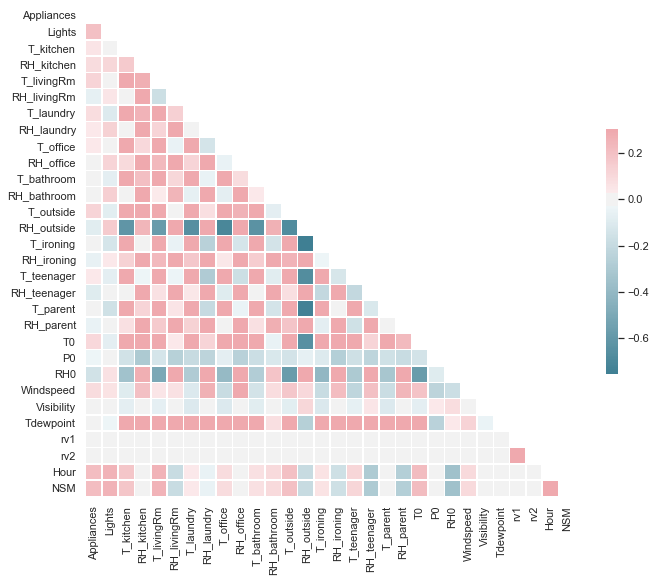

In [13]:
# plot a correlation matrix
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Correlation map observations
* Appliances and lights are weakly correlated with all features
* Features are weakly correlated, except for the outside humidity, RH_Outside, and temperature
* Dark red is weak positive correlation (+0.2)
* Dark blue is strong negative correlation (-0.7)

### Preliminary visualization of numerical features with boxplots 

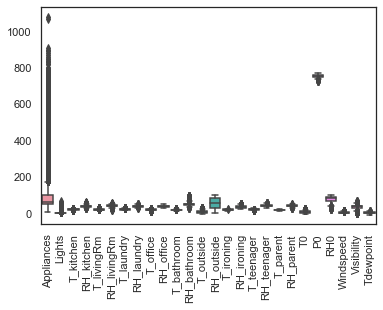

In [14]:
# remove the non-numeric features
df_numerics = df[['Appliances', 'Lights', 'T_kitchen', 'RH_kitchen', 'T_livingRm', 'RH_livingRm', 
              'T_laundry', 'RH_laundry', 'T_office', 'RH_office', 'T_bathroom', 'RH_bathroom', 
              'T_outside', 'RH_outside', 'T_ironing', 'RH_ironing', 'T_teenager','RH_teenager', 
              'T_parent', 'RH_parent', 'T0', 'P0', 'RH0', 'Windspeed','Visibility', 'Tdewpoint']]

# the boxplots
chart = sns.boxplot(data = df_numerics, orient = "v")
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

### Initial boxplot observations 
* The range of values for Appliances is wide and highly variable
* The range of values for Lights is not wide, but is highly variable
* The mean of pressure (P0) is large
* The range of all other features is relatively narrow

### Boxplots without Appliances and Lights; and with mean subtracted from all other features 

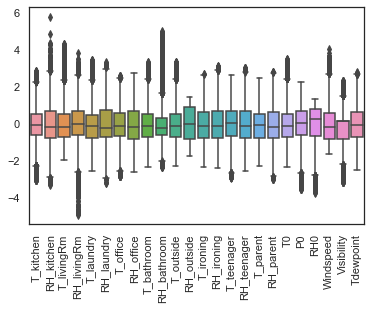

In [15]:
# remove the appliancses and lights
df_numerics_2 = df[['T_kitchen', 'RH_kitchen', 'T_livingRm', 'RH_livingRm', 
              'T_laundry', 'RH_laundry', 'T_office', 'RH_office', 'T_bathroom', 'RH_bathroom', 
              'T_outside', 'RH_outside', 'T_ironing', 'RH_ironing', 'T_teenager','RH_teenager', 
              'T_parent', 'RH_parent', 'T0', 'P0', 'RH0', 'Windspeed','Visibility', 'Tdewpoint']]

# subtract the mean from the remaining dataframe
df_numerics_normalized = (df_numerics_2 - df_numerics_2.mean())/df_numerics_2.std()

# the boxplots
chart = sns.boxplot(data = df_numerics_normalized, orient = "v")
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

### Final boxplot observations -- Jake

Observations:
- There are many outliers in the dataset
- Some room measurements are skewed for example room humidity in the bathroom is skewed right most likely due to the use of the shower and RH in the kitchen is skewed right possibly from increased himidty when cooking


### Visualizing the distribution of the dataset
* The Appliances and Lights are included

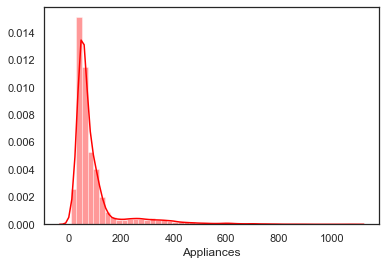

In [16]:
# visualize the distribution of the appliance energy use
sns.distplot( df.Appliances, color="red")

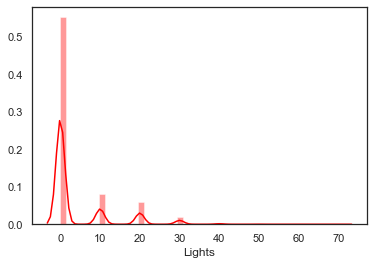

In [17]:
# visualize the distribution of the lighting energy use
sns.distplot( df.Lights , color="red")

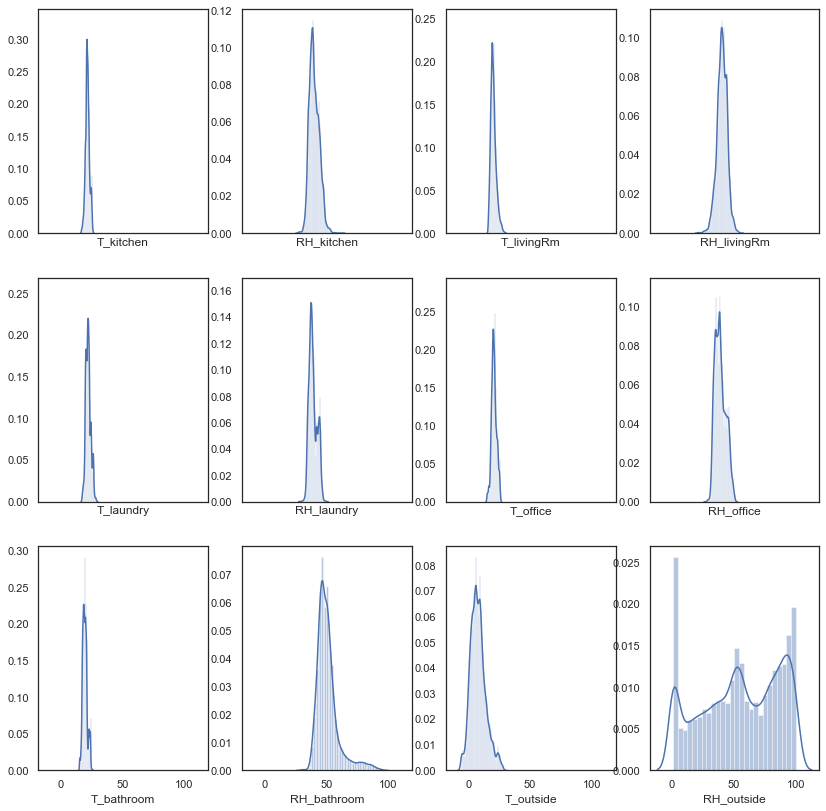

In [18]:
# visualize the distribution of the temperature and humidity in several rooms and the outside
f, axes = plt.subplots(3, 4, figsize=(14, 14), sharex=True)
sns.distplot( df.T_kitchen , ax=axes[0, 0])
sns.distplot( df.RH_kitchen , ax=axes[0, 1])
sns.distplot( df.T_livingRm , ax=axes[0, 2])
sns.distplot( df.RH_livingRm , ax=axes[0, 3])
sns.distplot( df.T_laundry , ax=axes[1, 0])
sns.distplot( df.RH_laundry , ax=axes[1, 1])
sns.distplot( df.T_office , ax=axes[1, 2])
sns.distplot( df.RH_office , ax=axes[1, 3])
sns.distplot( df.T_bathroom , ax=axes[2, 0])
sns.distplot( df.RH_bathroom , ax=axes[2, 1])
sns.distplot( df.T_outside , ax=axes[2, 2])
sns.distplot( df.RH_outside , ax=axes[2, 3])


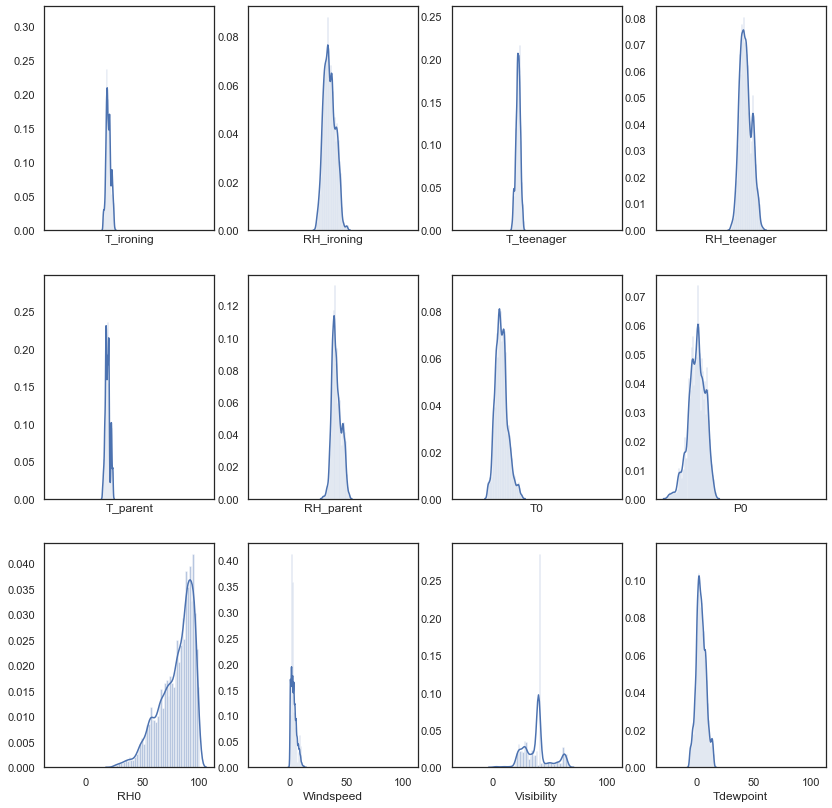

In [19]:
# visualize the distribution of the temperature and humidity in the remaining rooms and the weather at the nearby airport
f, axes = plt.subplots(3, 4, figsize=(14, 14), sharex=True)
sns.distplot( df.T_ironing , ax=axes[0, 0])
sns.distplot( df.RH_ironing , ax=axes[0, 1])
sns.distplot( df.T_teenager , ax=axes[0, 2])
sns.distplot( df.RH_teenager , ax=axes[0, 3])
sns.distplot( df.T_parent , ax=axes[1, 0])
sns.distplot( df.RH_parent , ax=axes[1, 1])
sns.distplot( df.T0 , ax=axes[1, 2])
sns.distplot( df.P0 - df.P0.mean() , ax=axes[1, 3])   # mean removed to avoid squashing the x-axis of the other features
sns.distplot( df.RH0 , ax=axes[2, 0])
sns.distplot( df.Windspeed , ax=axes[2, 1])
sns.distplot( df.Visibility , ax=axes[2, 2])
sns.distplot( df.Tdewpoint , ax=axes[2, 3])


### Distribution plot observations
* Except for RH_outide, all input features are nicely distributed and good ML candidates
* RH_outside may be a candidate for exclusion from the ML model.  Suggest testing accuracy with and without that feature.
* The appliances energy usage fluctuates over time, as expected
* The lighting energy usage is off most of the time (daylight hours), and has mostly discrete values (not contiuous values)

In [20]:
df['Day_of_week'].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

## Visualize hourly appliance usage


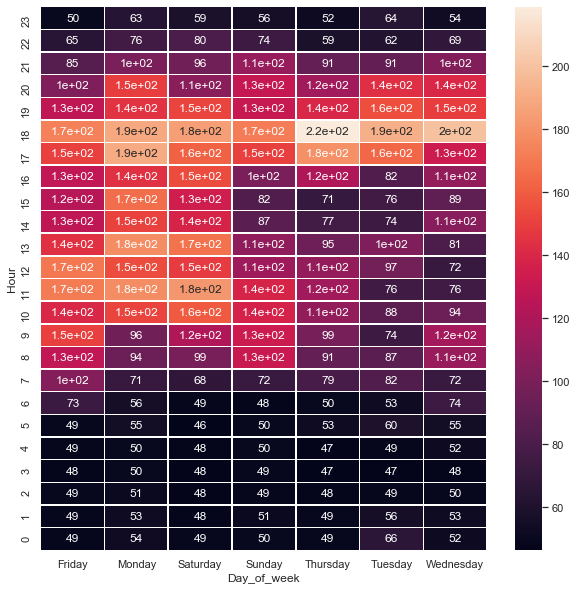

In [21]:
heatmap1_data = pd.pivot_table(df, values='Appliances', 
                     index=['Hour'], 
                     columns='Day_of_week')
fig, aa = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(heatmap1_data.iloc[:, 0:8], annot=True, linewidths=.5, aa=aa)
ax = plt.gca()
ax.invert_yaxis()
plt.show()

# Observation (Appliance Usage)
    -Peak appliance usage was found on Thursday at 1800 to 1900 (6pm to 7pm) at 220 kW/h.
    -Least amount of usage as expected, was during the 2200 to 0600 time frame.
    -Probable factors: AC unit, cooking, people getting home from work, and entertainment appliances.

## Visualize hourly light usage


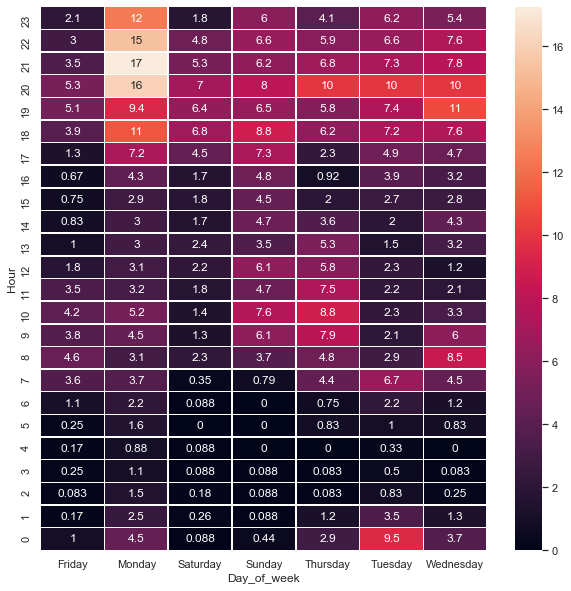

In [22]:
heatmap1_data = pd.pivot_table(df, values='Lights', 
                     index=['Hour'], 
                     columns='Day_of_week')
fig, aa = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(heatmap1_data.iloc[:, 0:8], annot=True, linewidths=.5, aa=aa)
ax = plt.gca()
ax.invert_yaxis()
plt.show()

# Observation (Light Usage)
    -Peak light usage was found on Monday from 2100 to 2300 at 15-17 kW/h.
    -Least amount of usage as expected, was during the 0000 to 0600 time frame.
    -Probable factors: people getting home from work and getting ready for the next day.

## Cull features for ML
The following features will not be used in the ML models
* date - replaced wirh Day_of_week, NSM
* rv1 - in original dataset, but not used
* rv2 - in original dataset, but not used
* Date - not needed for ML prediction, which will use Day_of_week, NSM
* Time - not needed for ML prediction, which will use Day_of_week, NSM
* Hour - not needed for ML prediction, which will use Day_of_week, NSM

In [23]:
dset = df.drop(['date', 'rv1', 'rv2', 'Date', 'Time', 'Hour'],  axis=1)
dset.head()

,Appliances,Lights,T_kitchen,RH_kitchen,T_livingRm,RH_livingRm,T_laundry,RH_laundry,T_office,RH_office,...,T_parent,RH_parent,T0,P0,RH0,Windspeed,Visibility,Tdewpoint,Day_of_week,NSM
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,Monday,61200
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,Monday,61800
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,Monday,62400
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,Monday,63000
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,Monday,63600


In [24]:
len(dset.columns)

28

## Get Dummies for day of the week

In [25]:
dset = pd.get_dummies(dset, columns=["Day_of_week"])
dset.head()

,Appliances,Lights,T_kitchen,RH_kitchen,T_livingRm,RH_livingRm,T_laundry,RH_laundry,T_office,RH_office,...,Visibility,Tdewpoint,NSM,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,63.000000,5.3,61200,0,1,0,0,0,0,0
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,59.166667,5.2,61800,0,1,0,0,0,0,0
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,55.333333,5.1,62400,0,1,0,0,0,0,0
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,51.500000,5.0,63000,0,1,0,0,0,0,0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,47.666667,4.9,63600,0,1,0,0,0,0,0


In [26]:
dset_X = dset.iloc[:,2:]

appliances_y = dset['Appliances']
lights_y = dset['Lights']

## Recursive feature elimination
Retrieve the 5 most informative features and rank the other 27. 
Repeat for Appliances and Lights

### Because each run takes 30 minutes, the code is commented out and the results are listed. instead

In [26]:
# # RFE is slow, so randomly select 5% of the rows
# dset1 = dset.sample(frac = 0.05)
# print(f"Original number of rows ${len(dset)}")
# print(f"Truncated number of rows ${len(dset1)}")

# # shape the truncated input and target variables
# X1 = dset1.iloc[:,2:]
# y1_1 = ravel(dset1["Appliances"].values.reshape(-1, 1))
# y1_2 = ravel(dset1["Lights"].values.reshape(-1, 1))

Appliances

In [27]:
# # execute RFE on Appliances
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, 5, step=1)
# selector = selector.fit(X1, y1_1)
# selector.support_
# selector.ranking_

In [28]:
# Resultant ranking of Appliance features
# Rank  Feature
# ====  ==========
#  1    'T_kitchen', 
#  2    'RH_kitchen', 
#  7    'T_livingRm',
#  5    'RH_livingRm', 
# 13    'T_laundry', 
# 11    'RH_laundry', 
#  8    'T_office', 
# 20    'RH_office',
# 15    'T_bathroom', 
# 24    'RH_bathroom', 
# 16    'T_outside', 
# 26    'RH_outside', 
#  4    'T_ironing',
# 25    'RH_ironing', 
#  1    'T_teenager', 
#  3    'RH_teenager', 
#  1    'T_parent', 
# 14    'RH_parent',
# 22    'T0', 
# 27    'P0', 
# 19    'RH0', 
# 12    'Windspeed', 
# 23    'Visibility', 
# 18    'Tdewpoint',
# 28    'Day_of_week_Friday', 
# 21    'Day_of_week_Monday', 
#  6    'Day_of_week_Saturday', 
#  1    'Day_of_week_Sunday', 
#  9    'Day_of_week_Thursday', 
# 17    'Day_of_week_Tuesday', 
#  1    'Day_of_week_Wednesday', 
# 10    'NSM'

In [40]:
# build a dataframe with top 5 RFE ranked features for Appliances
dset_RFE_1 = dset.loc[:, ['T_kitchen', 'T_teenager', 'T_parent', 'Day_of_week_Sunday', 'Day_of_week_Wednesday']]

Lights

In [27]:
# # execute RFE on Lights
# selector = RFE(estimator, 5, step=1)
# selector = selector.fit(X1, y1_2)
# selector.support_
# selector.ranking_

In [28]:
# Resultant ranking of Lights features
# Rank  Feature
# ====  ==========
#  8   'T_kitchen', 
#  9   'RH_kitchen', 
#  4   'T_livingRm',
# 13   'RH_livingRm', 
#  7   'T_laundry', 
# 17   'RH_laundry', 
#  1   'T_office', 
#  5   'RH_office',
#  1   'T_bathroom', 
# 21   'RH_bathroom', 
# 18   'T_outside', 
# 23   'RH_outside', 
#  2   'T_ironing',
# 14   'RH_ironing', 
#  3   'T_teenager', 
#  6   'RH_teenager', 
#  1   'T_parent', 
# 26   'RH_parent',
# 22   'T0', 
# 27   'P0', 
# 16   'RH0', 
# 11   'Windspeed', 
# 25   'Visibility', 
# 20   'Tdewpoint',
# 28   'Day_of_week_Friday', 
# 24   'Day_of_week_Monday', 
# 15   'Day_of_week_Saturday', 
# 10   'Day_of_week_Sunday', 
# 12   'Day_of_week_Thursday', 
#  1   'Day_of_week_Tuesday', 
#  1   'Day_of_week_Wednesday', 
# 19   'NSM'

In [27]:
# build a dataframe with top 5 RFE ranked features for Lights
dset_RFE_2 = dset.loc[:, ['T_office', 'T_bathroom', 'T_parent', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday']]

## Separate positively and negatively correlated features for Appliances and Lights

### First repeat the above correlation map, but with the individual days of the week included

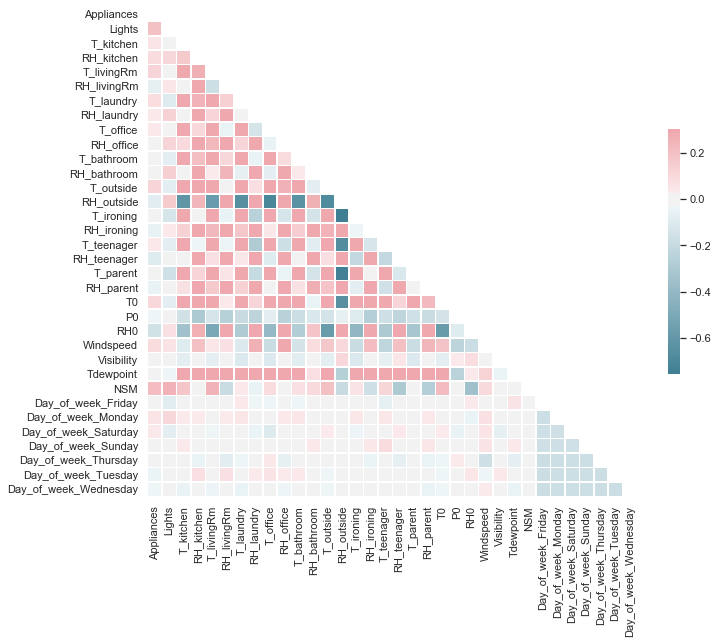

In [28]:
corr = dset.corr()
# plot a correlation matrix
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [29]:
# Using the above correlation map, separate the positively and negatively coorelated features for Appliances and Lights
# +, -, 'T_kitchen', 
# +, +, 'RH_kitchen', 
# +, -, 'T_livingRm',
# -, +, 'RH_livingRm', 
# +, -, 'T_laundry', 
# +, +, 'RH_laundry', 
# +, -, 'T_office', 
# -, +, 'RH_office',
# -, -, 'T_bathroom', 
# -, +, 'RH_bathroom', 
# +, -, 'T_outside', 
# +, +, 'RH_outside', 
# +, -, 'T_ironing',
# +, +, 'RH_ironing', 
# -, -, 'T_teenager', 
# +, -, 'RH_teenager', 
# +, -, 'T_parent', 
# +, -, 'RH_parent',
# -, -, 'T0', 
# +, -, 'P0', 
# +, +, 'RH0', 
# -, +, 'Windspeed', 
# +, -, 'Visibility', 
# +, -, 'Tdewpoint',
# -, -, 'Day_of_week_Friday', 
# +, +, 'Day_of_week_Monday', 
# +, -, 'Day_of_week_Saturday', 
# -, -, 'Day_of_week_Sunday', 
# -, -, 'Day_of_week_Thursday', 
# -, -, 'Day_of_week_Tuesday', 
# -, - 'Day_of_week_Wednesday', 
# +, + 'NSM'


In [30]:
# build the input dataframes with the selected features
dset_positive_1 = dset.loc[:, ['T_kitchen', 'RH_kitchen', 'T_livingRm', 'T_laundry', 'RH_laundry', 'T_office', 'T_outside', 'RH_outside', 'T_ironing', 'RH_ironing', 'RH_teenager', 'T_parent', 'RH_parent', 'P0', 'RH0', 'Visibility', 'Tdewpoint', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'NSM']]
dset_negative_1 = dset.loc[:, ['RH_livingRm', 'RH_office', 'T_bathroom', 'RH_bathroom', 'T_teenager', 'T0', 'Windspeed', 'Day_of_week_Friday', 'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday']]
dset_positive_2 = dset.loc [:, ['RH_kitchen', 'RH_livingRm', 'RH_laundry', 'RH_office', 'RH_bathroom', 'RH_outside', 'RH_ironing', 'RH0', 'Windspeed', 'Day_of_week_Monday', 'NSM']]
dset_negative_2 = dset.loc [:, [ 'T_kitchen', 'T_livingRm', 'T_laundry', 'T_office', 'T_bathroom', 'T_outside', 'T_ironing', 'T_teenager', 'RH_teenager', 'T_parent', 'RH_parent', 'T0', 'P0', 'Visibility', 'Tdewpoint', 'Day_of_week_Friday', 'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday']]


## The monster function
The MF is used for evaluating models with different feature sets.  The MF accepts a specific dataframe.  The MF iterates through multiple scalars, and for each iteration, the MF splits train/test, uses the selected scalar, calculates the r2 for each model, and outputs the scalar-model-r2 triples. 

In [31]:
# from sklearn.preprocessing import StandardScaler
# X_scaler_1 = StandardScaler().fit(X_train_1)
# y_scaler_1 = StandardScaler().fit(y_train_1)

# X_scaler_2 = StandardScaler().fit(X_train_2)
# y_scaler_2 = StandardScaler().fit(y_train_2)

# from sklearn.preprocessing import MinMaxScaler
# X_scaler_1 = MinMaxScaler().fit(X_train_1)
# y_scaler_1 = MinMaxScaler().fit(y_train_1)

# X_scaler_2 = MinMaxScaler().fit(X_train_2)
# y_scaler_2 = MinMaxScaler().fit(y_train_2)

# from sklearn.preprocessing import RobustScaler
# X_scaler_1 = RobustScaler().fit(X_train_1)
# y_scaler_1 = RobustScaler().fit(y_train_1)

# X_scaler_2 = RobustScaler().fit(X_train_2)
# y_scaler_2 = RobustScaler().fit(y_train_2)

from sklearn.preprocessing import PowerTransformer
X_scaler_1 = PowerTransformer().fit(X_train_1)
y_scaler_1 = PowerTransformer().fit(y_train_1)

X_scaler_2 = PowerTransformer().fit(X_train_2)
y_scaler_2 = PowerTransformer().fit(y_train_2)

NameError: name 'X_train_1' is not defined

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PowerTransformer
from sklearn import svm
from numpy import ravel
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

class Easy_ML(object):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.algorithms = ''
        self.description = "Steve, Stephen, and Jake's easy ml tool"
        self.results = {}
        best_score = 0

        
    def find_best_model(self):
        
        
        def transform_selection(ttype):
            if ttype == 'Power':
                transformer_object = PowerTransformer()
                return transformer_object
            
            if ttype == 'Standard':
                transformer_object = StandardScaler()
                return transformer_object
            
            if ttype == 'Min Max':
                transformer_object = MinMaxScaler()
                return transformer_object
            
            if ttype == 'Robust':
                transformer_object = RobustScaler()
                return transformer_object
            
    
        #reshape
        y = self.y.values.reshape(-1, 1)
        
        #split
        X_train, X_test, y_train, y_test = train_test_split(self.X, y, random_state=5)
        
        
        
        print ('Power Scalar:')
        print()
        
        #Power Scalar
        X_scaler_1 = transform_selection(ttype='Power').fit(X_train)
        y_scaler_1 = transform_selection(ttype='Power').fit(y_train)
        
        X_train_1 = X_scaler_1.transform(X_train)
        X_test_1 = X_scaler_1.transform(X_test)
        y_train_1 = y_scaler_1.transform(y_train)
        y_test_1 = y_scaler_1.transform(y_test)
        
        
        #linear regression
        linear_regression = LinearRegression()
        linear_regression.fit(X_train_1, y_train_1)
        predictions = linear_regression.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = linear_regression.score(X_test_1,y_test_1)
        self.results['Linear Regression (Power)'] = {'model':linear_regression,'MSE':MSE, 'R2':r2}
        print('Linear Regression: ' + str(self.results['Linear Regression (Power)']['R2']))
        
        #lasso
        lasso = Lasso(alpha=0.01).fit(X_train_1, y_train_1)
        predictions = lasso.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = lasso.score(X_test_1,y_test_1)
        self.results['Lasso (Power)'] = {'model':lasso,'MSE':MSE, 'R2':r2}
        print('Lasso: ' + str(self.results['Lasso (Power)']['R2']))
        
        #ridge
        ridge = Ridge(alpha=0.01).fit(X_train_1, y_train_1)
        predictions = ridge.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = ridge.score(X_test_1, y_test_1)
        self.results['Ridge (Power)'] = {'model':ridge,'MSE':MSE, 'R2':r2}
        print('Ridge: ' + str(self.results['Ridge (Power)']['R2']))
        
        #Elastic Net
        elasticnet = ElasticNet(alpha=.01).fit(X_train_1, y_train_1)
        predictions = elasticnet.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = elasticnet.score(X_test_1, y_test_1)
        self.results['Elastic Net (Power)'] = {'model':elasticnet,'MSE':MSE, 'R2':r2}
        print('Elastic Net: ' + str(self.results['Elastic Net (Power)']['R2']))
    
        #SVR
        svr = svm.SVR()
        y=ravel(y_train_1)
        svr.fit(X_train_1, y)
        predictions = svr.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = svr.score(X_test_1, y_test_1)
        self.results['SVR (Power)'] = {'model':SVR,'MSE':MSE, 'R2':r2}
        print('SVR: ' + str(self.results['SVR (Power)']['R2']))
        
        #RFR
        rfr = RandomForestRegressor(max_depth=20, random_state=0)
        y=ravel(y_train_1)
        rfr.fit(X_train_1, y)
        predictions = rfr.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = rfr.score(X_test_1, y_test_1)
        self.results['RFR (Power)'] = {'model':rfr,'MSE':MSE, 'R2':r2}
        print('RFR: ' + str(self.results['RFR (Power)']['R2']))
        print()
        print()
        print()
        
        
        print ('Standard Scalar:')
        print()
        
        #Power Scalar
        X_scaler_1 = transform_selection(ttype='Standard').fit(X_train)
        y_scaler_1 = transform_selection(ttype='Standard').fit(y_train)
        
        X_train_1 = X_scaler_1.transform(X_train)
        X_test_1 = X_scaler_1.transform(X_test)
        y_train_1 = y_scaler_1.transform(y_train)
        y_test_1 = y_scaler_1.transform(y_test)
        
        
        #linear regression
        linear_regression = LinearRegression()
        linear_regression.fit(X_train_1, y_train_1)
        predictions = linear_regression.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = linear_regression.score(X_test_1,y_test_1)
        self.results['Linear Regression (Standard)'] = {'model':linear_regression,'MSE':MSE, 'R2':r2}
        print('Linear Regression: ' + str(self.results['Linear Regression (Standard)']['R2']))
        
        #lasso
        lasso = Lasso(alpha=0.01).fit(X_train_1, y_train_1)
        predictions = lasso.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = lasso.score(X_test_1,y_test_1)
        self.results['Lasso (Standard)'] = {'model':lasso,'MSE':MSE, 'R2':r2}
        print('Lasso: ' + str(self.results['Lasso (Standard)']['R2']))
        
        #ridge
        ridge = Ridge(alpha=0.01).fit(X_train_1, y_train_1)
        predictions = ridge.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = ridge.score(X_test_1, y_test_1)
        self.results['Ridge (Standard)'] = {'model':ridge,'MSE':MSE, 'R2':r2}
        print('Ridge: ' + str(self.results['Ridge (Standard)']['R2']))
        
        #Elastic Net
        elasticnet = ElasticNet(alpha=.01).fit(X_train_1, y_train_1)
        predictions = elasticnet.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = elasticnet.score(X_test_1, y_test_1)
        self.results['Elastic Net (Standard)'] = {'model':elasticnet,'MSE':MSE, 'R2':r2}
        print('Elastic Net: ' + str(self.results['Elastic Net (Standard)']['R2']))
    
        #SVR
        svr = svm.SVR()
        y=ravel(y_train_1)
        svr.fit(X_train_1, y)
        predictions = svr.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = svr.score(X_test_1, y_test_1)
        self.results['SVR (Standard)'] = {'model':SVR,'MSE':MSE, 'R2':r2}
        print('SVR: ' + str(self.results['SVR (Standard)']['R2']))
        
        #RFR
        rfr = RandomForestRegressor(max_depth=20, random_state=0)
        y=ravel(y_train_1)
        rfr.fit(X_train_1, y)
        predictions = rfr.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = rfr.score(X_test_1, y_test_1)
        self.results['RFR (Standard)'] = {'model':rfr,'MSE':MSE, 'R2':r2}
        print('RFR: ' + str(self.results['RFR (Standard)']['R2']))
        print()
        print()
        print()
        
        
        print ('Min Max Scalar:')
        print()
        
        #Power Scalar
        X_scaler_1 = transform_selection(ttype='Min Max').fit(X_train)
        y_scaler_1 = transform_selection(ttype='Min Max').fit(y_train)
        
        X_train_1 = X_scaler_1.transform(X_train)
        X_test_1 = X_scaler_1.transform(X_test)
        y_train_1 = y_scaler_1.transform(y_train)
        y_test_1 = y_scaler_1.transform(y_test)
        
        
        #linear regression
        linear_regression = LinearRegression()
        linear_regression.fit(X_train_1, y_train_1)
        predictions = linear_regression.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = linear_regression.score(X_test_1,y_test_1)
        self.results['Linear Regression (Min Max)'] = {'model':linear_regression,'MSE':MSE, 'R2':r2}
        print('Linear Regression: ' + str(self.results['Linear Regression (Min Max)']['R2']))
        
        #lasso
        lasso = Lasso(alpha=0.01).fit(X_train_1, y_train_1)
        predictions = lasso.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = lasso.score(X_test_1,y_test_1)
        self.results['Lasso (Min Max)'] = {'model':lasso,'MSE':MSE, 'R2':r2}
        print('Lasso: ' + str(self.results['Lasso (Min Max)']['R2']))
        
        #ridge
        ridge = Ridge(alpha=0.01).fit(X_train_1, y_train_1)
        predictions = ridge.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = ridge.score(X_test_1, y_test_1)
        self.results['Ridge (Min Max)'] = {'model':ridge,'MSE':MSE, 'R2':r2}
        print('Ridge: ' + str(self.results['Ridge (Min Max)']['R2']))
        
        #Elastic Net
        elasticnet = ElasticNet(alpha=.01).fit(X_train_1, y_train_1)
        predictions = elasticnet.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = elasticnet.score(X_test_1, y_test_1)
        self.results['Elastic Net (Min Max)'] = {'model':elasticnet,'MSE':MSE, 'R2':r2}
        print('Elastic Net: ' + str(self.results['Elastic Net (Min Max)']['R2']))
    
        #SVR
        svr = svm.SVR()
        y=ravel(y_train_1)
        svr.fit(X_train_1, y)
        predictions = svr.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = svr.score(X_test_1, y_test_1)
        self.results['SVR (Min Max)'] = {'model':SVR,'MSE':MSE, 'R2':r2}
        print('SVR: ' + str(self.results['SVR (Min Max)']['R2']))
        
        #RFR
        rfr = RandomForestRegressor(max_depth=20, random_state=0)
        y=ravel(y_train_1)
        rfr.fit(X_train_1, y)
        predictions = rfr.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = rfr.score(X_test_1, y_test_1)
        self.results['RFR (Min Max)'] = {'model':rfr,'MSE':MSE, 'R2':r2}
        print('RFR: ' + str(self.results['RFR (Min Max)']['R2']))
        print()
        print()
        print()
        
        print ('Robust Scalar:')
        print()
        
        #Power Scalar
        X_scaler_1 = transform_selection(ttype='Robust').fit(X_train)
        y_scaler_1 = transform_selection(ttype='Robust').fit(y_train)
        
        X_train_1 = X_scaler_1.transform(X_train)
        X_test_1 = X_scaler_1.transform(X_test)
        y_train_1 = y_scaler_1.transform(y_train)
        y_test_1 = y_scaler_1.transform(y_test)
        
        
        #linear regression
        linear_regression = LinearRegression()
        linear_regression.fit(X_train_1, y_train_1)
        predictions = linear_regression.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = linear_regression.score(X_test_1,y_test_1)
        self.results['Linear Regression (Robust)'] = {'model':linear_regression,'MSE':MSE, 'R2':r2}
        print('Linear Regression: ' + str(self.results['Linear Regression (Robust)']['R2']))
        
        #lasso
        lasso = Lasso(alpha=0.01).fit(X_train_1, y_train_1)
        predictions = lasso.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = lasso.score(X_test_1,y_test_1)
        self.results['Lasso (Robust)'] = {'model':lasso,'MSE':MSE, 'R2':r2}
        print('Lasso: ' + str(self.results['Lasso (Robust)']['R2']))
        
        #ridge
        ridge = Ridge(alpha=0.01).fit(X_train_1, y_train_1)
        predictions = ridge.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = ridge.score(X_test_1, y_test_1)
        self.results['Ridge (Robust)'] = {'model':ridge,'MSE':MSE, 'R2':r2}
        print('Ridge: ' + str(self.results['Ridge (Robust)']['R2']))
        
        #Elastic Net
        elasticnet = ElasticNet(alpha=.01).fit(X_train_1, y_train_1)
        predictions = elasticnet.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = elasticnet.score(X_test_1, y_test_1)
        self.results['Elastic Net (Robust)'] = {'model':elasticnet,'MSE':MSE, 'R2':r2}
        print('Elastic Net: ' + str(self.results['Elastic Net (Robust)']['R2']))
    
        #SVR
        svr = svm.SVR()
        y=ravel(y_train_1)
        svr.fit(X_train_1, y)
        predictions = svr.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = svr.score(X_test_1, y_test_1)
        self.results['SVR (Robust)'] = {'model':SVR,'MSE':MSE, 'R2':r2}
        print('SVR: ' + str(self.results['SVR (Robust)']['R2']))
        
        #RFR
        rfr = RandomForestRegressor(max_depth=20, random_state=0)
        y=ravel(y_train_1)
        rfr.fit(X_train_1, y)
        predictions = rfr.predict(X_test_1)
        MSE = mean_squared_error(y_test_1, predictions)
        r2 = rfr.score(X_test_1, y_test_1)
        self.results['RFR (Robust)'] = {'model':rfr,'MSE':MSE, 'R2':r2}
        print('RFR: ' + str(self.results['RFR (Robust)']['R2']))
        
        return self.results
        

## Evaluate the models for r2 scores, using dataframes with different feature sets

### The initial dataframe for appliances

In [33]:
# MF(dset)
appliances_model_1 = Easy_ML(dset_X, appliances_y)
best_model_1 = appliances_model_1.find_best_model()

Power Scalar:

Linear Regression: 0.2689474532834527
Lasso: 0.24695254950037726
Ridge: 0.2689473938253154
Elastic Net: 0.25702405991207045
SVR: 0.5091929008406599
RFR: 0.7232012296032468



Standard Scalar:

Linear Regression: 0.14479950520929374
Lasso: 0.12528956414033698
Ridge: 0.14479966135185862
Elastic Net: 0.13345598119068236
SVR: 0.232527342536322
RFR: 0.5990515030632805



Min Max Scalar:

Linear Regression: 0.14479950520929397
Lasso: -0.0005441951007114643
Ridge: 0.14480831567076158
Elastic Net: 0.01334184955467188
SVR: 0.11966357115858839
RFR: 0.5974228858217645



Robust Scalar:

Linear Regression: 0.14479950520929386
Lasso: 0.1322270711285196
Ridge: 0.14479982084216025
Elastic Net: 0.13672682828622762
SVR: 0.17936586992560533
RFR: 0.5985797665454622


In [57]:
models = []
r2_vals = []
mse_vals = []
for key,value in best_model_1.items():
    models.append(key)
    r2_vals.append(value['R2'])
    mse_vals.append(value['MSE'])
df = pd.DataFrame({'models':models, 'r2 values':r2_vals, 'MSE values': mse_vals})

df.to_csv('model_1_app.csv')
df

,models,r2 values,MSE values
0,Linear Regression (Power),0.268947,0.721518
1,Lasso (Power),0.246953,0.743226
2,Ridge (Power),0.268947,0.721518
3,Elastic Net (Power),0.257024,0.733286
4,SVR (Power),0.509193,0.484406
5,RFR (Power),0.723201,0.273189
6,Linear Regression (Standard),0.144800,0.933844
7,Lasso (Standard),0.125290,0.955148
8,Ridge (Standard),0.144800,0.933844
9,Elastic Net (Standard),0.133456,0.946231


### Initial Dataframe for lights

In [35]:
lights_model_1 = Easy_ML(dset_X, lights_y)
best_model_2 = lights_model_1.find_best_model()

Power Scalar:

Linear Regression: 0.2013257212165589
Lasso: 0.1896539951264251
Ridge: 0.2013258564570244
Elastic Net: 0.19393798316851307
SVR: 0.33035895753805633
RFR: 0.5552595724760665



Standard Scalar:

Linear Regression: 0.2382299117621345
Lasso: 0.22368102816056812
Ridge: 0.2382299707762214
Elastic Net: 0.22947598153239657
SVR: 0.41392016828687916
RFR: 0.7023148718555753



Min Max Scalar:

Linear Regression: 0.23822991176213426
Lasso: -0.00018937355741366346
Ridge: 0.23823103915283406
Elastic Net: 0.050551925785891294
SVR: 0.33643422898926034
RFR: 0.7033476176391477



Robust Scalar:

Linear Regression: 0.23822991176213426
Lasso: 0.23690928956902435
Ridge: 0.2382299721191715
Elastic Net: 0.23474305100914816
SVR: 0.1378732637537472
RFR: 0.7014235271626963


In [36]:
models = []
r2_vals = []
mse_vals = []
for key,value in best_model_2.items():
    models.append(key)
    r2_vals.append(value['R2'])
    mse_vals.append(value['MSE'])
df = pd.DataFrame({'models':models, 'r2 values':r2_vals, 'MSE values': mse_vals})
df.to_csv('model_1_lights.csv')
df

,models,r2 values,MSE values
0,Linear Regression (Power),0.201326,0.793112
1,Lasso (Power),0.189654,0.804702
2,Ridge (Power),0.201326,0.793112
3,Elastic Net (Power),0.193938,0.800448
4,SVR (Power),0.330359,0.664977
5,RFR (Power),0.555260,0.441643
6,Linear Regression (Standard),0.238230,0.733798
7,Lasso (Standard),0.223681,0.747813
8,Ridge (Standard),0.238230,0.733798
9,Elastic Net (Standard),0.229476,0.742231


### The dataframe with the top 5 RFE ranked features for Appliances

In [42]:
# MF(dset_RFE_1)
appliance_model = Easy_ML(dset_RFE_1, appliances_y)
best_model = appliance_model.find_best_model()

Power Scalar:

Linear Regression: 0.04913980158039977
Lasso: 0.048618089605007686
Ridge: 0.04913983722628501
Elastic Net: 0.049390816630308754
SVR: 0.0858369895778135
RFR: 0.5353074601341761



Standard Scalar:

Linear Regression: 0.00738850948661296
Lasso: 0.006324543579251274
Ridge: 0.007388519522215198
Elastic Net: 0.007352154976347668
SVR: -0.07044183240613688
RFR: 0.42371256657991013



Min Max Scalar:

Linear Regression: 0.007388509486612849
Lasso: -0.0005441951007114643
Ridge: 0.0073887561256814616
Elastic Net: -0.0005441951007114643
SVR: -0.17906259333774302
RFR: 0.4229471492294755



Robust Scalar:

Linear Regression: 0.007388509486612959
Lasso: 0.0068782413048460445
Ridge: 0.007388528116090254
Elastic Net: 0.00739849306932594
SVR: -0.08410924104925499
RFR: 0.42523579071442025


In [43]:
models = []
r2_vals = []
mse_vals = []
for key,value in best_model.items():
    models.append(key)
    r2_vals.append(value['R2'])
    mse_vals.append(value['MSE'])
df = pd.DataFrame({'models':models, 'r2 values':r2_vals, 'MSE values': mse_vals})
df.to_csv('top5_rfe_app.csv')
df

,models,r2 values,MSE values
0,Linear Regression (Power),0.049140,0.938459
1,Lasso (Power),0.048618,0.938974
2,Ridge (Power),0.049140,0.938459
3,Elastic Net (Power),0.049391,0.938211
4,SVR (Power),0.085837,0.902240
5,RFR (Power),0.535307,0.458632
6,Linear Regression (Standard),0.007389,1.083891
7,Lasso (Standard),0.006325,1.085053
8,Ridge (Standard),0.007389,1.083891
9,Elastic Net (Standard),0.007352,1.083931


### The dataframe with the top 5 RFE ranked features for Lights

In [44]:
# MF(dset_RFE_2)
lights_model = Easy_ML(dset_RFE_2, lights_y)
best_model = lights_model.find_best_model()

Power Scalar:

Linear Regression: 0.09323615898582904
Lasso: 0.09197542026420902
Ridge: 0.09323621509655788
Elastic Net: 0.09291608464288736
SVR: 0.0013347785676333102
RFR: 0.42018313810792746



Standard Scalar:

Linear Regression: 0.11128933781367056
Lasso: 0.10986367811099816
Ridge: 0.11128941005095183
Elastic Net: 0.11085458298152374
SVR: 0.03143051361625704
RFR: 0.5085147932817042



Min Max Scalar:

Linear Regression: 0.11128933781367045
Lasso: -0.00018937355741366346
Ridge: 0.11129123086308855
Elastic Net: -0.00018937355741366346
SVR: -0.12654136387805237
RFR: 0.5109302992518165



Robust Scalar:

Linear Regression: 0.11128933781367023
Lasso: 0.11151897131476984
Ridge: 0.11128945739732332
Elastic Net: 0.11133122224936354
SVR: -0.05375747271773301
RFR: 0.510097121292636


In [45]:
models = []
r2_vals = []
mse_vals = []
for key,value in best_model.items():
    models.append(key)
    r2_vals.append(value['R2'])
    mse_vals.append(value['MSE'])
df = pd.DataFrame({'models':models, 'r2 values':r2_vals, 'MSE values': mse_vals})
df.to_csv('top5_rfe_lights.csv')
df

,models,r2 values,MSE values
0,Linear Regression (Power),0.093236,0.900449
1,Lasso (Power),0.091975,0.901701
2,Ridge (Power),0.093236,0.900449
3,Elastic Net (Power),0.092916,0.900767
4,SVR (Power),0.001335,0.991710
5,RFR (Power),0.420183,0.575779
6,Linear Regression (Standard),0.111289,0.856078
7,Lasso (Standard),0.109864,0.857451
8,Ridge (Standard),0.111289,0.856078
9,Elastic Net (Standard),0.110855,0.856497


### The dataframe with all features that are positively correlated with Appliances

In [47]:
# MF(dset_positive_1)
appliance_model = Easy_ML(dset_positive_1, appliances_y)
best_model = appliance_model.find_best_model()

Power Scalar:

Linear Regression: 0.24318813127688332
Lasso: 0.23046388320936684
Ridge: 0.24318806040546093
Elastic Net: 0.23533826265616073
SVR: 0.477997459571957
RFR: 0.7211003731970016



Standard Scalar:

Linear Regression: 0.13030136306064788
Lasso: 0.11612943453596924
Ridge: 0.13030126260855812
Elastic Net: 0.12272580688454882
SVR: 0.1971994235329437
RFR: 0.6037424629374971



Min Max Scalar:

Linear Regression: 0.13030136306064777
Lasso: -0.0005441951007114643
Ridge: 0.13029872130830855
Elastic Net: 0.01334184955467188
SVR: 0.10660317510499584
RFR: 0.6055937447670652



Robust Scalar:

Linear Regression: 0.130301363060648
Lasso: 0.12174369833630437
Ridge: 0.13030120108796783
Elastic Net: 0.12407878286583385
SVR: 0.15236359199519922
RFR: 0.6061670900041767


In [48]:
models = []
r2_vals = []
mse_vals = []
for key,value in best_model.items():
    models.append(key)
    r2_vals.append(value['R2'])
    mse_vals.append(value['MSE'])
df = pd.DataFrame({'models':models, 'r2 values':r2_vals, 'MSE values': mse_vals})
df.to_csv('pos_corr_app.csv')
df

,models,r2 values,MSE values
0,Linear Regression (Power),0.243188,0.746941
1,Lasso (Power),0.230464,0.759500
2,Ridge (Power),0.243188,0.746941
3,Elastic Net (Power),0.235338,0.754689
4,SVR (Power),0.477997,0.515194
5,RFR (Power),0.721100,0.275262
6,Linear Regression (Standard),0.130301,0.949675
7,Lasso (Standard),0.116129,0.965151
8,Ridge (Standard),0.130301,0.949675
9,Elastic Net (Standard),0.122726,0.957948


### The dataframe with all features that are positively correlated with Lights

In [49]:
# MF(dset_positive_2)
lights_model = Easy_ML(dset_positive_2, lights_y)
best_model = lights_model.find_best_model()

Power Scalar:

Linear Regression: 0.12601013271143435
Lasso: 0.12464178632359492
Ridge: 0.1260101629716358
Elastic Net: 0.1258729073242143
SVR: 0.15843018775351114
RFR: 0.5400522980783424



Standard Scalar:

Linear Regression: 0.12872928601017364
Lasso: 0.12745521047712316
Ridge: 0.12872932188842123
Elastic Net: 0.12903745668288802
SVR: 0.20869630790405713
RFR: 0.6706202765628927



Min Max Scalar:

Linear Regression: 0.1287292860101733
Lasso: -0.00018937355741366346
Ridge: 0.12873119798658306
Elastic Net: 0.050551925785891294
SVR: 0.0848367557671652
RFR: 0.6690715962729612



Robust Scalar:

Linear Regression: 0.1287292860101732
Lasso: 0.1290418008574663
Ridge: 0.12872935328209734
Elastic Net: 0.12917074627591552
SVR: 0.0017482021409092052
RFR: 0.6692542137950085


In [50]:
models = []
r2_vals = []
mse_vals = []
for key,value in best_model.items():
    models.append(key)
    r2_vals.append(value['R2'])
    mse_vals.append(value['MSE'])
df = pd.DataFrame({'models':models, 'r2 values':r2_vals, 'MSE values': mse_vals})
df.to_csv('pos_corr_lights.csv')
df

,models,r2 values,MSE values
0,Linear Regression (Power),0.126010,0.867903
1,Lasso (Power),0.124642,0.869262
2,Ridge (Power),0.126010,0.867903
3,Elastic Net (Power),0.125873,0.868039
4,SVR (Power),0.158430,0.835709
5,RFR (Power),0.540052,0.456744
6,Linear Regression (Standard),0.128729,0.839278
7,Lasso (Standard),0.127455,0.840506
8,Ridge (Standard),0.128729,0.839278
9,Elastic Net (Standard),0.129037,0.838981


### The dataframe with all features that are negatively correlated with Appliances

In [52]:
# MF(dset_negative_1)
appliance_model = Easy_ML(dset_negative_1, appliances_y)
best_model = appliance_model.find_best_model()

Power Scalar:

Linear Regression: 0.07347308823690146
Lasso: 0.07152499438903914
Ridge: 0.07347312285544216
Elastic Net: 0.07344345269939478
SVR: 0.3026818620174939
RFR: 0.7039791279645354



Standard Scalar:

Linear Regression: 0.02024879577861738
Lasso: 0.02045250087999395
Ridge: 0.02024881749031382
Elastic Net: 0.021215739205231787
SVR: 0.06701549598678214
RFR: 0.5777972709846155



Min Max Scalar:

Linear Regression: 0.02024879577861738
Lasso: -0.0005441951007114643
Ridge: 0.0202494149084973
Elastic Net: -0.0005441951007114643
SVR: -0.07942442733350807
RFR: 0.5779618849287542



Robust Scalar:

Linear Regression: 0.02024879577861749
Lasso: 0.02089841338459375
Ridge: 0.020248847236219558
Elastic Net: 0.021202432932102777
SVR: 0.04465796972063907
RFR: 0.576282828271669


In [53]:
models = []
r2_vals = []
mse_vals = []
for key,value in best_model.items():
    models.append(key)
    r2_vals.append(value['R2'])
    mse_vals.append(value['MSE'])
df = pd.DataFrame({'models':models, 'r2 values':r2_vals, 'MSE values': mse_vals})
df.to_csv('neg_corr_app.csv')
df

,models,r2 values,MSE values
0,Linear Regression (Power),0.073473,0.914443
1,Lasso (Power),0.071525,0.916365
2,Ridge (Power),0.073473,0.914443
3,Elastic Net (Power),0.073443,0.914472
4,SVR (Power),0.302682,0.688223
5,RFR (Power),0.703979,0.292160
6,Linear Regression (Standard),0.020249,1.069848
7,Lasso (Standard),0.020453,1.069626
8,Ridge (Standard),0.020249,1.069848
9,Elastic Net (Standard),0.021216,1.068792


### The dataframe with all features that are negatively correlated with Lights

In [54]:
# MF(dset_negative_2)
lights_model = Easy_ML(dset_negative_2, lights_y)
best_model = lights_model.find_best_model()

Power Scalar:

Linear Regression: 0.14335085994133012
Lasso: 0.13460730951989686
Ridge: 0.14335105235928514
Elastic Net: 0.14067617691042011
SVR: 0.23500440181443774
RFR: 0.5457897182323319



Standard Scalar:

Linear Regression: 0.16506826581289225
Lasso: 0.1563838452189883
Ridge: 0.16506861623651647
Elastic Net: 0.16278705724217457
SVR: 0.29836900086062634
RFR: 0.6838648927875135



Min Max Scalar:

Linear Regression: 0.1650682658128918
Lasso: -0.00018937355741366346
Ridge: 0.16507729931367088
Elastic Net: -0.00018937355741366346
SVR: 0.21794201387598844
RFR: 0.6820027089385574



Robust Scalar:

Linear Regression: 0.1650682658128917
Lasso: 0.16508659070419807
Ridge: 0.16506883888227786
Elastic Net: 0.16458412871944295
SVR: -0.027926360125766218
RFR: 0.6848343245377356


In [55]:
models = []
r2_vals = []
mse_vals = []
for key,value in best_model.items():
    models.append(key)
    r2_vals.append(value['R2'])
    mse_vals.append(value['MSE'])
df = pd.DataFrame({'models':models, 'r2 values':r2_vals, 'MSE values': mse_vals})
df.to_csv('neg_corr_lights.csv')
df

,models,r2 values,MSE values
0,Linear Regression (Power),0.143351,0.850683
1,Lasso (Power),0.134607,0.859366
2,Ridge (Power),0.143351,0.850683
3,Elastic Net (Power),0.140676,0.853339
4,SVR (Power),0.235004,0.759668
5,RFR (Power),0.545790,0.451047
6,Linear Regression (Standard),0.165068,0.804274
7,Lasso (Standard),0.156384,0.812639
8,Ridge (Standard),0.165069,0.804273
9,Elastic Net (Standard),0.162787,0.806471
